In [234]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import numpy as np
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12
import pickle
C =cosmology.Planck15

from IPython.core.debugger import Tracer

In [3]:
states = pd.Index(('BD', 'RD', 'RE')) #only considering blue disks, red disks, red ellipticals


In [335]:
# Set rates per galaxy in Gyr^{-1} at fiducial redshift
rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((3, 3)))
rates['from BD']['to RD'] = 0.05191961
rates['from RD']['to RE'] = 0.03981438
rates['from BD']['to RE'] = 0.05124415
rates

,from BD,from RD,from RE
to BD,0.000000,0.000000,0
to RD,0.051920,0.000000,0
to RE,0.051244,0.039814,0


In [336]:
def alpha(a_s,M_star,m):
    alpha = (1+a_s) - m/M_star
    return alpha
def sSFR(t):
    sSFR = 2.5*(t/3.5)**(-2.2)
    return sSFR
def rate_matrix(rates,m,t):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    rate_mtrx = pd.DataFrame(data=np.zeros((3, 3)))
    a_s = -1.4 
    M_star = 10.82
    rate_mtrx[0][0] = -rates['from BD']['to RD'] - rates['from BD']['to RE'] - alpha(a_s,M_star,m)*sSFR(t)
    rate_mtrx[0][1] = rates['from BD']['to RD']
    rate_mtrx[0][2] = rates['from BD']['to RE']
    rate_mtrx[1][2] = rates['from RD']['to RE']
    rate_mtrx[2][2] = .5*rates['from RE']['to RE']
    return rate_mtrx
def plot_NF(F_RD,F_DR):
    colors = '#54235c'
    fig, (axrd, axdr) = plt.subplots(1, 2, figsize=(12, 6))
    F_RD.plot(ax=axrd,colors=colors,lw=2)
    axrd.set(xlabel='$z$', ylabel='$f_{R|D}(z)$', ylim=(0, .4));
    F_DR.plot(ax=axdr,colors=colors,lw=2)
    axdr.set(xlabel='$z$')
    axdr.set(ylabel='$f_{D|R}(z)$', ylim=(0, 0.4));
    plt.tight_layout()
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


In [337]:
def modelrates(N, t, rates, rate_matrix_fn, m):
    rate_mtrx = rate_matrix_fn(rates,m,t)
    return np.dot(rate_mtrx, N)

In [338]:
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)
m_edges = [10.1,10.4,10.7,11,11.3]
m_centers = [(m_edges[i]+m_edges[i+1])/2. for i in range(0,len(m_edges)-1)]


In [339]:
N0=pd.Series(index=states)
N0['BD'] = results['M={}'.format(m_centers[3])]['N_BD'][3]
N0['RD'] = results['M={}'.format(m_centers[3])]['N_RD'][3]
N0['RE'] = results['M={}'.format(m_centers[3])]['N_RE'][3]

In [340]:
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value
m=m_centers[3]

In [341]:
N = odeint(modelrates, N0, t, args=(rates, rate_matrix, m))

In [342]:
N = pd.DataFrame(index=z, columns='$N_{' + states + '}$', data=N)
N = N[::-1] #number evolution of BD,RD,RE

In [343]:
F_RD = pd.DataFrame(index=N.index) #evolution of fractions
F_DR = pd.DataFrame(index=N.index) #evolution of fractions
F_RD = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{BD}$'])
F_DR = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{RE}$'])


In [344]:
model_f_rid = [F_RD[i] for i in model_z]
model_f_dir = [F_DR[i] for i in model_z]
    
model = np.array(model_f_rid + model_f_dir) #model values of f_RD and f_DR at 4 redshifts
model

array([ 0.13587843,  0.13045291,  0.17021261,  0.29447958,  0.39021168,
        0.33443385,  0.29099884,  0.26875512])

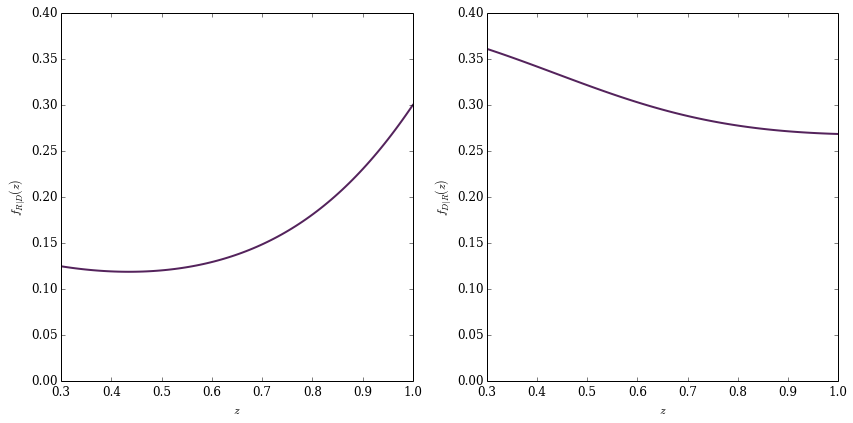

In [300]:
plot_NF(F_RD,F_DR)

In [60]:
#centers of bins where f_rid and f_dir are evaluated in the data
z_centers = [0.3125, 0.53750000000000009, 0.76250000000000007, 0.98750000000000004]
z_centers = [round(z,2) for z in z_centers]


## MCMC 1-D attempt

In [197]:
#"real" data
x=np.array(z_centers+z_centers) #observed redshifts X 2 
y=np.array(results['M=%s'%m_centers[3]]['f_RID']+results['M=%s'%m_centers[3]]['f_DIR']) #observed f_RD, f_DR at observed redshifts
yerr = np.array(results['M=%s'%m_centers[3]]['f_RID_err']+results['M=%s'%m_centers[3]]['f_DIR_err'])
model_z = [find_nearest(z,i) for i in z_centers] #closest redshift in model to observed redshift values

In [326]:
#log likelihood function
def lnlike(theta, x, y, yerr):
    bd_rd, bd_re, rd_re, lnf = theta #rate parameters 
    Tracer()()
    #theta = [ 0.0463397 ,  0.06313405,  0.04610793, -2.29785313]
    rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((3, 3)))
    rates['from BD']['to RD'] = bd_rd
    rates['from RD']['to RE'] = rd_re
    rates['from BD']['to RE'] = bd_re

    N = odeint(modelrates, N0, t, args=(rates, rate_matrix, m))
    N = pd.DataFrame(index=z, columns='$N_{' + states + '}$', data=N)
    N = N[::-1] #number evolution of BD,RD,RE
    F_RD = pd.DataFrame(index=N.index) #evolution of fractions
    F_DR = pd.DataFrame(index=N.index) #evolution of fractions
    F_RD = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{BD}$'])
    F_DR = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{RE}$'])
    
    model_f_rid = [F_RD[i] for i in model_z]
    model_f_dir = [F_DR[i] for i in model_z]
    
    model = np.array(model_f_rid + model_f_dir) #model values of f_RD and f_DR at 4 redshifts
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    answer = -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    if np.isnan(answer):
        answer=-np.inf
    return answer


In [321]:
#prior -restrictions on m 
def lnprior(theta):
    bd_rd, bd_re, rd_re, lnf = theta
    #Tracer()()
    if .001 < bd_rd < .1 and .001 < bd_re < .1 and .001 < rd_re < .1 and -10.0 < lnf < 1.0:
        return 0.0
    #Tracer()()
    return -np.inf


In [319]:
#check that parameters fit within lnprior bounds; if not, return np.inf, if is, return lnlike(theta,x,y,yerr) (why +lp???)
def lnprob(theta, x, y, yerr):
    #Tracer()()
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    answer = lp + lnlike(theta, x, y, yerr)
    #return lp + lnlike(theta, x, y, yerr)
    return answer

In [311]:
ndim, nwalkers = 4, 100
pos = [np.array([.05,.05,.05,np.log(.1)]) + .01*np.random.randn(ndim) for i in range(nwalkers)] #choosing starting locations at random guess .05 for each rate


In [327]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr),a=0.02)


In [328]:
sampler.run_mcmc(pos, 500);


> <ipython-input-326-02b387381c9d>(6)lnlike()
      5     #theta = [ 0.0463397 ,  0.06313405,  0.04610793, -2.29785313]
----> 6     rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
      7                      data=np.zeros((3, 3)))

ipdb> p theta
array([ 0.05191961,  0.03981438,  0.05124415, -2.31090535])
ipdb> p model
[0.020571361154533632, 0.015698130535529625, 0.015114864859546748, 0.022116106622594563, 0.49192267411897705, 0.48567013464250997, 0.47168679226635246, 0.45284726549357973]
ipdb> q
emcee: Exception while calling your likelihood function:
  params: [ 0.05191961  0.03981438  0.05124415 -2.31090535]
  args: (array([ 0.31,  0.54,  0.76,  0.99,  0.31,  0.54,  0.76,  0.99]), array([ 0.2247191 ,  0.22608696,  0.28125   ,  0.3       ,  0.16745327,
        0.21922622,  0.21351034,  0.26839497]), array([ 0.04290897,  0.03361552,  0.02389916,  0.02347015,  0.03329557,
        0.03275096,  0.01900121,  0.02147632]))
  kwargs: {}
  exception:
Exiting Debugger.


Traceback (most recent call last):
  File "build/bdist.linux-x86_64/egg/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-319-df42caf357ec>", line 7, in lnprob
    answer = lp + lnlike(theta, x, y, yerr)
  File "<ipython-input-326-02b387381c9d>", line 6, in lnlike
    rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
  File "<ipython-input-326-02b387381c9d>", line 6, in lnlike
    rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
  File "/usr/lib/python2.7/bdb.py", line 49, in trace_dispatch
    return self.dispatch_line(frame)
  File "/usr/lib/python2.7/bdb.py", line 68, in dispatch_line
    if self.quitting: raise BdbQuit
BdbQuit


In [324]:
[ 0.13587843,  0.13045291,  0.17021261,  0.29447958,  0.39021168,
        0.33443385,  0.29099884,  0.26875512]

-inf

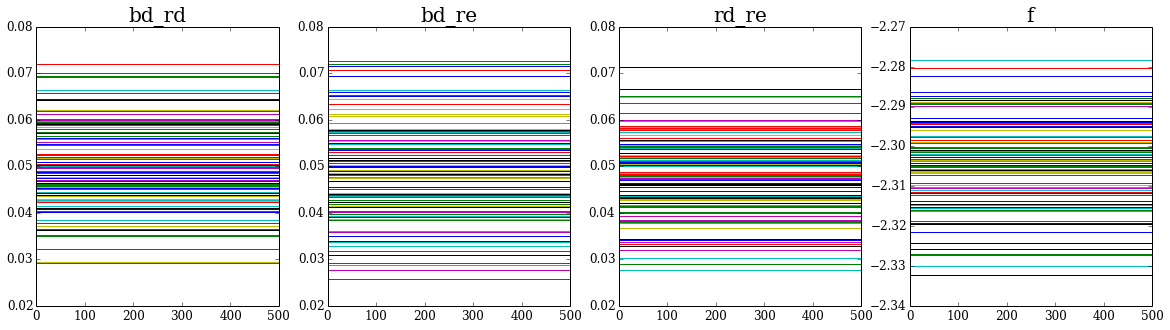

In [314]:
xp=np.linspace(1,500,500)

f=plt.figure(figsize=(20,5))
ax=plt.subplot(141)
for i in range(0,100):
    plt.plot(xp,sampler.chain[i,:,0])
plt.title('bd_rd',fontsize=20)
ax=plt.subplot(142)
for i in range(0,100):
    plt.plot(xp,sampler.chain[i,:,1])
plt.title('bd_re',fontsize=20)
ax=plt.subplot(143)
for i in range(0,100):
    plt.plot(xp,sampler.chain[i,:,2])
plt.title('rd_re',fontsize=20)
ax=plt.subplot(144)
for i in range(0,100):
    plt.plot(xp,sampler.chain[i,:,3])
plt.title('f',fontsize=20)

In [207]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [.01, .01,.01, np.log(.1)], args=(x, y, yerr))


/usr/local/lib/python2.7/dist-packages/scipy/integrate/odepack.py:156: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [217]:
result["x"]

array([ -1.94672327e+09,  -2.08007713e+09,  -2.08994664e+09,
        -2.09250497e+09])